In [25]:
import numpy as np
from astropy import units as u
from astropy.io import fits
import copy
import poppy
from model_kit import magaoxFunctions as mf
import matplotlib.pyplot as plt
import matplotlib

def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))

In [3]:
# Open loop calculations
# initial conditions
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'n_tests': 10,
           'n_loop': 4,
           'set': 0,
           'bump': True,
           'wfe_data': 'allopd'} # other: 'allopd', 'common'

# set up prescription details
wavelen_str = str(np.round(fr_parm['wavelength'].to(u.nm).value).astype(int))
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2}nm'.format(fr_parm['npix'], br, wavelen_str)

# set up file locations
home_dir = '/home/jhen/XWCL/code/MagAOX/' # change for exao0
data_dir = home_dir + 'data/'
psf_mask_dir = data_dir + 'mask_psf/'
fr_out_dir = 'data_fig/n0_allopd/'

tweeter_num = 16
vappTRANS_num = 23
vappOPD_num = vappTRANS_num+1

# set the vAPP masks
vAPP_dir = data_dir+ 'coronagraph/'
vAPP_trans_filename = 'vAPP_trans_2PSF_{0}'.format(parm_name)
vAPP_posOPD_filename = 'vAPP_opd_2PSF_{0}_posPhase'.format(parm_name)
vAPP_negOPD_filename = 'vAPP_opd_2PSF_{0}_negPhase'.format(parm_name)

# tweeter mask
tw_mask = fits.open(data_dir+'mask/lyot_tweeter_amp_mask_bump_538.fits')[0].data

### PSF Pieces

In [7]:
%%time
# generate the non-aberrated vAPP PSF

# load the CSV prescription values
rx_loc_difflim = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}_noap_{1}.csv'.format(parm_name, 
                                                                              'nowfe')
rx_difflim = mf.makeRxCSV(rx_loc_difflim)

# initialize the arrays
psf_tot_dl = np.zeros((fr_parm['npix'], fr_parm['npix']))
rx_difflim[vappTRANS_num]['surf_PSD_filename'] = 'none'
rx_difflim[vappOPD_num]['surf_PSD_filename'] = 'none'

vapp_name = ['leak', 'pos', 'neg']
for j_v in range(0, len(vapp_name)):
    set_vapp = vapp_name[j_v]
    if set_vapp == 'leak':
        # only change the mask
        rx_difflim[vappTRANS_num]['surf_PSD_filename'] = vAPP_trans_filename
        log_str = 'Leak PSF (0 phase) complete'
    elif set_vapp == 'pos':
        # change OPD to positive phase
        rx_difflim[vappOPD_num]['surf_PSD_filename'] = vAPP_posOPD_filename
        log_str = 'Bottom PSF (+phase) complete'
    elif set_vapp == 'neg':
        # change OPD to negative phase
        rx_difflim[vappOPD_num]['surf_PSD_filename'] = vAPP_negOPD_filename
        log_str = 'Top PSF (-phase) complete'

    magaox = mf.csvFresnel(rx_csv=rx_difflim, 
                        samp=fr_parm['npix'], 
                        oversamp=fr_parm['beam_ratio'],
                        home_folder=home_dir, 
                        break_plane='F69Sci', 
                        bump=fr_parm['bump'])
    vapp_psf_obj = magaox.calc_psf(wavelength=fr_parm['wavelength'].value)[0]
    vapp_psf = poppy.utils.pad_or_crop_to_shape(vapp_psf_obj.data, (fr_parm['npix'], fr_parm['npix']))
        
    # multiply the leak PSF by the multiplier
    if set_vapp == 'leak':
        vapp_psf *= fr_parm['leak_mult']
        vapp_leak = vapp_psf
    elif set_vapp == 'pos':
        vapp_pos = vapp_psf
    elif set_vapp == 'neg':
        vapp_neg = vapp_psf
        
    # sum the PSFs together
    psf_tot_dl += vapp_psf
    print(log_str)

Leak PSF (0 phase) complete
Bottom PSF (+phase) complete
Top PSF (-phase) complete
CPU times: user 3min 15s, sys: 39.1 s, total: 3min 54s
Wall time: 1min 37s


In [13]:
# calculate the lambda/D scale factor per pixel
psf_hdr = vapp_psf_obj.header
fnum_det = 69
platescl = 206265*u.arcsec / (psf_hdr['DIAM']*u.m * fnum_det)
LD_scale = (1/platescl) * (1/(psf_hdr['PIXELSCL'] * u.m / u.pix)) * (psf_hdr['DIFFLMT'] * u.arcsec)
# ever 7.9 pixels is 1 L/D

# set the scaling range for the PSF axis
box = int(fr_parm['npix']/2) # Half the size of the window region of interest
rk = np.linspace(-box, box, (box*2), endpoint=False) * u.pix
rks = (rk / LD_scale).value

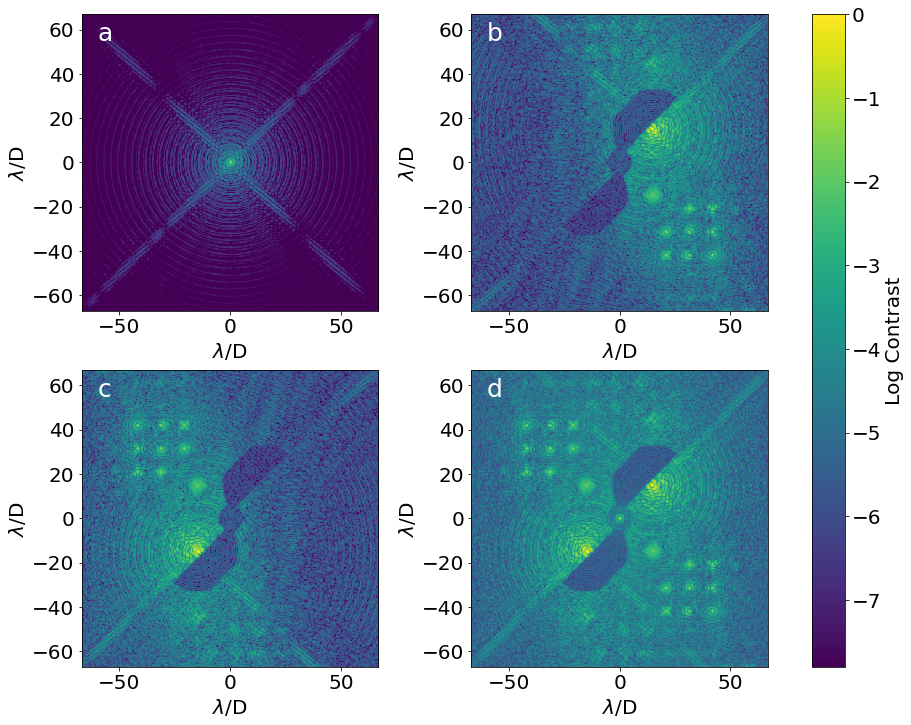

In [45]:
psf_norm = np.amax(psf_tot_dl)
cont_dl = psf_tot_dl/psf_norm

matplotlib.rcParams["font.size"]=20
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16,12), facecolor='white')#, dpi=100)

axes[0][0].imshow(np.log10(vapp_leak/psf_norm), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=-7.8, vmax=0)
axes[0][0].set_ylabel('$\lambda$/D')
axes[0][0].set_xlabel('$\lambda$/D')
axes[0][0].text(-60, 55, 'a', fontsize=25, color='white') #verticalalignment='top', horizontalalignment='left')
         
# second psf: open loop
#ax2 = plt.subplot(132)
axes[0][1].imshow(np.log10(vapp_neg/psf_norm), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=-7.8, vmax=0)
axes[0][1].set_ylabel('$\lambda$/D')
axes[0][1].set_xlabel('$\lambda$/D')
axes[0][1].text(-60, 55, 'b', fontsize=25, color='white')

# third psf: DM corrected
#ax3 = plt.subplot(133)
axes[1][0].imshow(np.log10(vapp_pos/psf_norm), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=-7.8, vmax=0)
axes[1][0].set_ylabel('$\lambda$/D')
axes[1][0].set_xlabel('$\lambda$/D')
axes[1][0].text(-60, 55, 'c', fontsize=25, color='white')

im = axes[1][1].imshow(np.log10(cont_dl), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=-7.8, vmax=0)
axes[1][1].set_ylabel('$\lambda$/D')
axes[1][1].set_xlabel('$\lambda$/D')
axes[1][1].text(-60, 55, 'd', fontsize=25, color='white')

fig.colorbar(im, ax=axes).set_label('Log Contrast')
plt.show()

### PSF Comparison
Must run `PSF Pieces` section first to get the non-aberrated PSF

In [26]:
# Calculate the dark hole contrast for the non-aberrated PSF
# open all the masks
top_circ = fits.open(psf_mask_dir + 'psf_top_circle_{0}.fits'.format(fr_parm['npix']))[0].data
bot_circ = fits.open(psf_mask_dir + 'psf_bot_circle_{0}.fits'.format(fr_parm['npix']))[0].data
top_dhmask = fits.open(psf_mask_dir + 'psf_top_dhmask_{0}.fits'.format(fr_parm['npix']))[0].data
bot_dhmask = fits.open(psf_mask_dir + 'psf_bot_dhmask_{0}.fits'.format(fr_parm['npix']))[0].data

psf_top_circ = cont_dl*top_circ
psf_top_circ /= np.amax(psf_top_circ)
dh_top_best = rms(psf_top_circ[top_dhmask==1])

psf_bot_circ = cont_dl*bot_circ
psf_bot_circ /= np.amax(psf_bot_circ)
dh_bot_best = rms(psf_bot_circ[bot_dhmask==1])

In [28]:
# open up the Fresnel calculated PSFs
psf_tot_open = fits.open(fr_out_dir+'psf_mwfs_allopd_s2_i0_656nm_tot.fits')[0].data
psf_tot_closed = fits.open(fr_out_dir+'psf_mwfs_allopd_s2_656nm_tot.fits')[0].data

# Hard-code in the avg and std dev
# can find these numbers in analysis_allopd_cal.ipynb
dh_bot_closed_avg = 1.144e-4
dh_bot_closed_std = 1.340e-5
dh_bot_open_avg = 4.345e-4
dh_bot_open_std = 8.322e-5

dh_top_closed_avg = 1.168e-4
dh_top_closed_std = 1.205e-5
dh_top_open_avg = 4.855e-4
dh_top_open_std = 8.696e-5

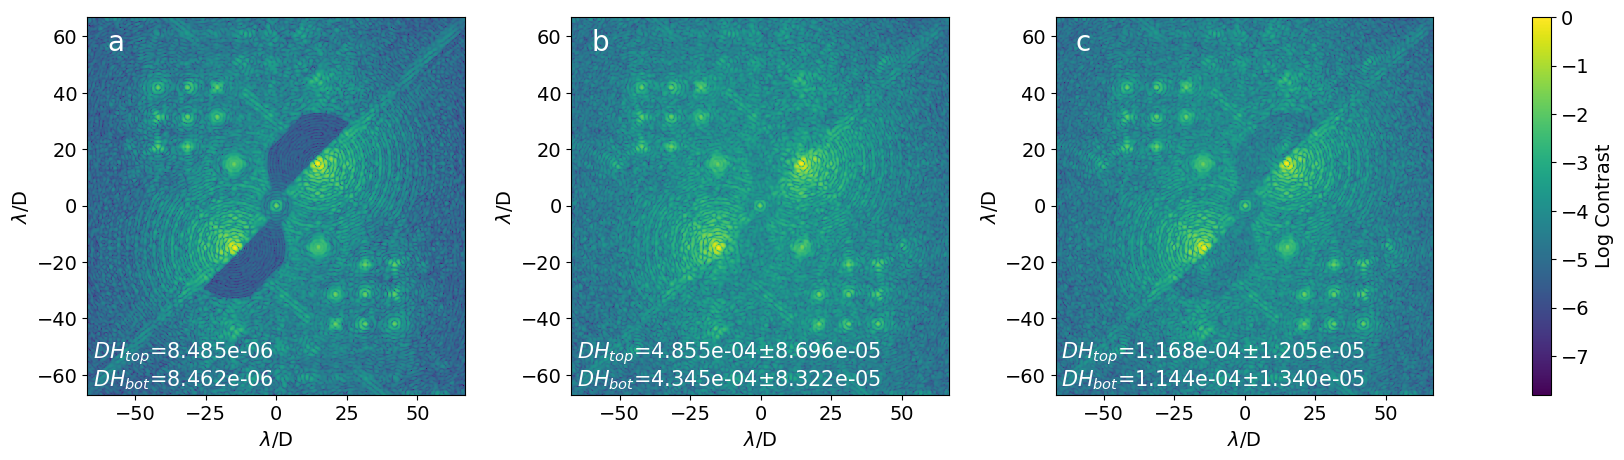

In [46]:
# fix the psf contrasts
cont_open = psf_tot_open/np.amax(psf_tot_open)
cont_closed = psf_tot_closed/np.amax(psf_tot_closed)

matplotlib.rcParams["font.size"]=14
#fig, axs = plt.subplots(1, 3, figsize=(20,5), dpi=100)

# first psf: diff limited
fig, (ax1, ax2, ax3, cax) = plt.subplots(ncols=4, figsize=(19,5), dpi=100,
                                         gridspec_kw={"width_ratios":[1,1,1, 0.05]},
                                         facecolor='white')
fig.subplots_adjust(wspace=0.3)
#ax1 = plt.subplot(1314
ax1.imshow(np.log10(cont_dl), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=-7.8, vmax=0)
ax1.set_ylabel('$\lambda$/D')
ax1.set_xlabel('$\lambda$/D')
ax1.text(-60, 55, 'a', fontsize=20, color='white')
ax1.text(-65, -54, '{0}={1:.3e}'.format(r'$DH_{top}$',dh_top_best),
         fontsize=15, color='white')
ax1.text(-65, -64, '{0}={1:.3e}'.format(r'$DH_{bot}$',dh_bot_best),
         fontsize=15, color='white')
         
# second psf: open loop
#ax2 = plt.subplot(132)
ax2.imshow(np.log10(cont_open), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=-7.8, vmax=0)
ax2.set_ylabel('$\lambda$/D')
ax2.set_xlabel('$\lambda$/D')
ax2.text(-60, 55, 'b', fontsize=20, color='white')
ax2.text(-65, -54, '{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{top}$',dh_top_open_avg,dh_top_open_std),
         fontsize=15, color='white')
ax2.text(-65, -64, '{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{bot}$',dh_bot_open_avg, dh_bot_open_std),
         fontsize=15, color='white')

# third psf: DM corrected
#ax3 = plt.subplot(133)
cbar_map = ax3.imshow(np.log10(cont_closed), origin='lower',
           extent=[np.amin(rks), np.amax(rks), np.amin(rks), np.amax(rks)],
           vmin=-7.8, vmax=0)
ax3.set_ylabel('$\lambda$/D')
ax3.set_xlabel('$\lambda$/D')
ax3.text(-60, 55, 'c', fontsize=20, color='white')
ax3.text(-65, -54, '{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{top}$',dh_top_closed_avg,dh_top_closed_std),
         fontsize=15, color='white')
ax3.text(-65, -64, '{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{bot}$',dh_bot_closed_avg, dh_bot_closed_std),
         fontsize=15, color='white')

fig.colorbar(cbar_map, cax=cax).set_label('Log Contrast')
plt.show()